In [13]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time
import gzip
import os
import struct

import pickle

In [34]:
# repeating the data prep from the previous notebook
NROWS = 32
NCOLS = 32

def load_batch():
    path = ''
    fileList = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5' ]
    fileTest = 'test_batch'
    for file in fileList:
        print(file)
        f = open(path+file, 'rb')
        dict = pickle.load(f, encoding='latin1')
        images = dict['data']
        images = numpy.reshape(images, (10000, 3, 32, 32))
        images = numpy.transpose(images, (0, 2, 3, 1))
        labels = dict['labels']
        if file == 'data_batch_1':
            x_train = numpy.array(images)   #   (10000, 3072)
            y_train = numpy.array(labels)   #   (10000,)
        else:
            x_train = numpy.concatenate((x_train, images), axis=0)
            y_train = numpy.concatenate((y_train, labels), axis=0)
        
    f = open(path+file, 'rb')
    dict = pickle.load(f, encoding='latin1')
    images = dict['data']
    images = numpy.reshape(images, (10000, 3, 32, 32))
    images = numpy.transpose(images, (0, 2, 3, 1))
    labels = dict['labels']
    x_test = numpy.array(images)   #   (10000, 3072)
    y_test = numpy.array(labels)   #   (10000,)
        
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_batch()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

data_batch_1
data_batch_2
data_batch_3
data_batch_4
data_batch_5
(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [35]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

In [36]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    
    return history, cnn_model

In [37]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)


Epoch 1/3
98/98 [==============================] - 6s 8ms/step - loss: 1.7587 - accuracy: 0.3631
Epoch 2/3
98/98 [==============================] - 1s 6ms/step - loss: 1.4204 - accuracy: 0.4911
Epoch 3/3
98/98 [==============================] - 1s 6ms/step - loss: 1.2770 - accuracy: 0.5469


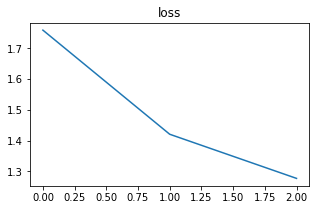

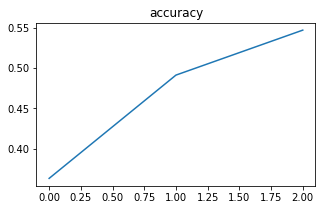

In [38]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [39]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 1.0710 - accuracy: 0.6334 - 622ms/epoch - 2ms/step
accuracy: 63.34%
CPU times: user 903 ms, sys: 317 ms, total: 1.22 s
Wall time: 820 ms


In [40]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 0s 852us/step
[[680  25  70  24  15   6   4  17 139  34]
 [ 41 731   9   9   6  14  15  11  71 107]
 [ 61   8 509  55 105 114  29  35  25  11]
 [ 16   5 112 458  59 259  40  35  18  14]
 [ 43   7 154  65 533  67  33  75  18   2]
 [ 11   4  67 152  57 650  14  54   8   8]
 [  1   5  95  98 110  54 582  17   6  12]
 [ 13   4  32  32  70 121   6 677   7  15]
 [ 72  29  26  23   3  14   5   4 805  22]
 [ 49 113  13  26   2  16  11  29  54 709]]

Classification accuracy for each class:

0: 0.6706
1: 0.7209
2: 0.5347
3: 0.4508
4: 0.5346
5: 0.6341
6: 0.5939
7: 0.6929
8: 0.8026
9: 0.6937


In [41]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred) 

In [42]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [43]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [44]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [45]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 1.4 seconds for epoch #0
beginning epoch 1
took 0.8 seconds for epoch #1
beginning epoch 2
took 0.8 seconds for epoch #2


In [55]:
class CIFAR10Classifier2(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='leaky_relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='leaky_relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv_4 = tf.keras.layers.Conv2D(128, [3, 3], activation='leaky_relu')
        self.conv_5 = tf.keras.layers.Conv2D(256, [3, 3], activation='leaky_relu')
        self.pool_6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        
        self.drop_7 = tf.keras.layers.Dropout(0.25)
        self.dense_8 = tf.keras.layers.Dense(256, activation='leaky_relu')
        self.dense_9 = tf.keras.layers.Dense(512, activation='leaky_relu')
        self.drop_10 = tf.keras.layers.Dropout(0.5)
        
        self.dense_11 = tf.keras.layers.Dense(128, activation='leaky_relu')
        self.dense_12 = tf.keras.layers.Dense(64, activation='leaky_relu')
        self.dense_13 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.pool_6(x)
        
        x = self.drop_7(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_8(x)
        x = self.dense_9(x)
        x = self.drop_10(x)
        
        x = self.dense_11(x)
        x = self.dense_12(x)
        x = self.dense_13(x)

        return x

In [56]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier2()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    
    return history, cnn_model

In [59]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 20
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)


Epoch 1/20
98/98 [==============================] - 1s 9ms/step - loss: 1.7581 - accuracy: 0.3400
Epoch 2/20
98/98 [==============================] - 1s 9ms/step - loss: 1.2609 - accuracy: 0.5434
Epoch 3/20
98/98 [==============================] - 1s 9ms/step - loss: 1.0086 - accuracy: 0.6426
Epoch 4/20
98/98 [==============================] - 1s 10ms/step - loss: 0.8323 - accuracy: 0.7073
Epoch 5/20
98/98 [==============================] - 1s 10ms/step - loss: 0.7130 - accuracy: 0.7489
Epoch 6/20
98/98 [==============================] - 1s 9ms/step - loss: 0.6316 - accuracy: 0.7781
Epoch 7/20
98/98 [==============================] - 1s 10ms/step - loss: 0.5410 - accuracy: 0.8093
Epoch 8/20
98/98 [==============================] - 1s 10ms/step - loss: 0.4836 - accuracy: 0.8310
Epoch 9/20
98/98 [==============================] - 1s 9ms/step - loss: 0.4278 - accuracy: 0.8494
Epoch 10/20
98/98 [==============================] - 1s 9ms/step - loss: 0.3785 - accuracy: 0.8665
Epoch 11/20
98/

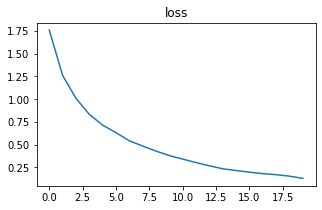

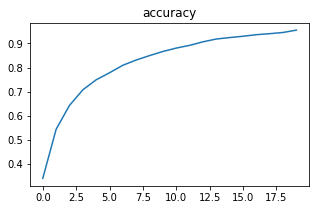

In [60]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In my experiment, I add more layers to the network, and change the nonlinear function to leaky relu, after 20 epochs, the accuracy becomes 95%. According to the loss, the slope is not fully converged, so if we do more epochs, we can get a better loss and accuracy!